In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = '/content/drive/My Drive/SI670/kaggle1/Greenwood'
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Greenwood_training.csv', 'greenwood_extra_credits.ipynb', 'Greenwood.csv']

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('Greenwood_training.csv')

In [ ]:
training_val_orig = df.copy()

In [ ]:
training_val_orig = training_val_orig.pivot(index='Depth_m',columns='Date_Time')['Water_Temp_C'].T

In [ ]:
training_val_orig.head()

Depth_m,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,14.5,16.5,18.5,20.5,22.5,24.5,26.5,28.5
Date_Time,,,,,,,,,,,,,,,,,,,,
2013-12-01 00:00:00,0.687,0.577,0.687,0.687,0.687,0.632,0.715,0.770,0.825,0.742,0.907,0.797,0.989,1.071,1.071,1.126,1.099,1.262,1.289,1.425
2013-12-01 01:00:00,0.687,0.605,0.687,0.687,0.687,0.632,0.715,0.770,0.825,0.742,0.907,0.770,0.989,1.071,1.071,1.126,1.099,1.262,1.289,1.453
2013-12-01 02:00:00,0.687,0.605,0.687,0.687,0.687,0.632,0.742,0.797,0.825,0.742,0.907,0.797,0.989,1.071,1.071,1.126,1.099,1.262,1.289,1.453
2013-12-01 03:00:00,0.687,0.605,0.687,0.715,0.687,0.660,0.742,0.797,0.825,0.742,0.934,0.797,0.989,1.071,1.071,1.126,1.099,1.262,1.289,1.453
2013-12-01 04:00:00,0.687,0.605,0.687,0.715,0.687,0.632,0.742,0.770,0.825,0.742,0.934,0.797,0.989,1.071,1.071,1.126,1.099,1.235,1.289,1.453


In [ ]:
training_val_orig.shape

(35010, 20)

In [ ]:
35010/2

17505.0

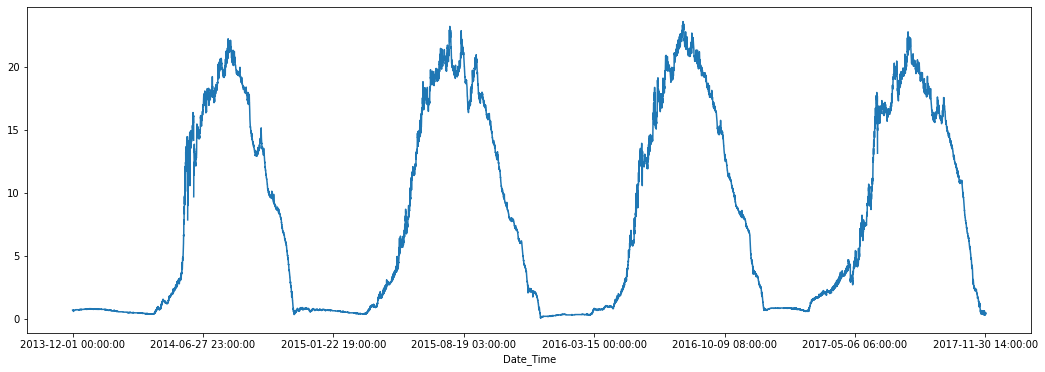

In [ ]:
training_val_orig[1.5].plot(figsize=(18,6))

In [ ]:
training_val_orig.isna().sum()

Depth_m
1.5      4
2.5      8
3.5     18
4.5     12
5.5      7
6.5     22
7.5     52
8.5     71
9.5     65
10.5    39
11.5    19
12.5    24
14.5     9
16.5     5
18.5     2
20.5     1
22.5     0
24.5     0
26.5     0
28.5     0
dtype: int64

In [ ]:
training_val_orig.dropna(inplace=True)

In [ ]:
training_val_orig.isna().sum()

Depth_m
1.5     0
2.5     0
3.5     0
4.5     0
5.5     0
6.5     0
7.5     0
8.5     0
9.5     0
10.5    0
11.5    0
12.5    0
14.5    0
16.5    0
18.5    0
20.5    0
22.5    0
24.5    0
26.5    0
28.5    0
dtype: int64

In [ ]:
training_val_orig.shape

(34681, 20)

In [ ]:
training_val = training_val_orig.iloc[-17500:].copy() # the recent 2 years of temperature

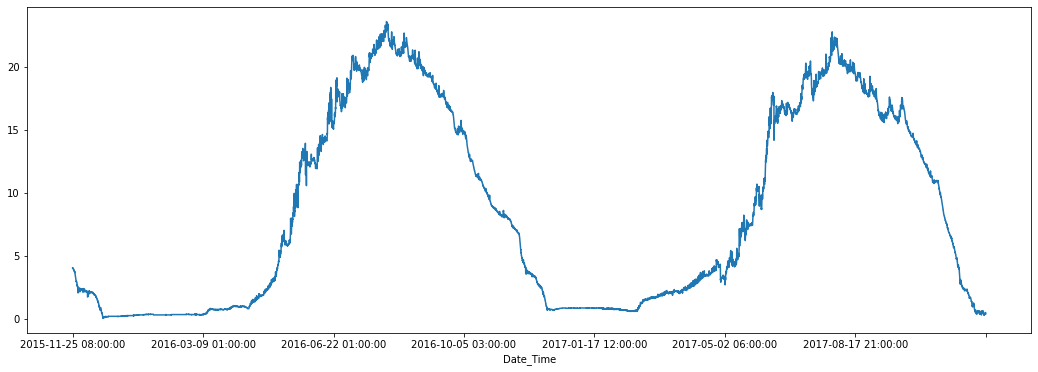

In [ ]:
training_val[1.5].plot(figsize=(18,6))

In [ ]:
import math
import numpy
import pandas
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

numpy.random.seed(2019)

In [ ]:
class RNNModel(object):
  def __init__(self, data, depth, look_back=1, epochs_temp=20, batch_size=1, verbose=2, patience=10, test_size=100, store_result=False):
      self.look_back = look_back
      self.epochs_temp = epochs_temp
      self.batch_size = batch_size
      self.verbose = verbose
      self.patience = patience
      self.store_result = store_result
      self.test_size = test_size
      self.temp = data
      self.depth = depth
      
  def access_data(self, data_frame):
      # load the data set
      data_set = data_frame.values
      data_set = data_set.astype('float32')

      # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
      # It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
      scaler = MinMaxScaler(feature_range=(0, 1))
      data_set = scaler.fit_transform(data_set)

      # reshape into X=t and Y=t+1
      train_x, train_y, test = self.create_data_set(data_set)

      # reshape input to be [samples, time steps, features]
      train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
      return train_x, train_y, test, scaler

  # convert an array of values into a data set matrix
  def create_data_set(self, data_set):
      data_x, data_y = [], []
      for i in range(len(data_set)-self.look_back - self.test_size):
          a = data_set[i:(i + self.look_back), 0]
          data_x.append(a)
          data_y.append(list(data_set[i + self.look_back: i + self.look_back + self.test_size, 0]))
      return numpy.array(data_x), numpy.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)

  def rnn_model(self, train_x, train_y, epochs):
      model = Sequential()
      model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
      model.add(LSTM(32, return_sequences=False))
      model.add(Dense(32))
      model.add(Dense(self.test_size))  # output is test_size numbers
      model.compile(loss='mean_squared_error', optimizer='adam')
      # model.summary()
      early_stopping = EarlyStopping('loss', patience=self.patience)
      history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
      return model

  def predict(self, model, data):
      prediction = model.predict(data)
      return prediction

  def run(self):
      temp_train_x, temp_train_y, temp_test, temp_scaler = self.access_data(self.temp)

      temp_model = self.rnn_model(temp_train_x, temp_train_y, self.epochs_temp)

      temp_train_pred = self.predict(temp_model, temp_train_x)
      print(mean_squared_error(temp_train_y,temp_train_pred))

      temp_predict = self.predict(temp_model, temp_test)

      temp = temp_scaler.inverse_transform(temp_predict).reshape(self.test_size,1)
      temp_ds = pandas.DataFrame({self.depth: list(temp)})

      return temp_ds  # with loop       

In [ ]:
def multi_step_test(data,depth,look_back=3,test_size = 744):
  output = []
  for i in range(38):  # (the param in range())*test_size must > 744, 744/20 = 37.2, so 38 loops is needed
    initiation = RNNModel(data=data,depth=depth,look_back=look_back, test_size=test_size, epochs_temp=6, batch_size=16, verbose=2, patience=50, store_result=False)
    temp_ds = initiation.run()
    output+=list(temp_ds.values)
    data = pd.concat([data,temp_ds],axis=0)
  return output[:744]  # 744 time points

In [ ]:
def temp_pred(depth,look_back=3,test_size=744):
  data = training_val[[depth]]
  temp = multi_step_test(data,depth,look_back=look_back,test_size=test_size)
  out_df[depth] = temp
  out_df[depth] = out_df[depth].apply(lambda x: x[0][0])
  return out_df

In [ ]:
out_df = pd.DataFrame()
for depth in training_val.columns:
  print(depth)
  temp_pred(depth,3,20)
print('finish')

流式输出内容被截断，只能显示最后 5000 行内容。
1135/1135 - 3s - loss: 3.6379e-04
Epoch 3/6
1135/1135 - 3s - loss: 3.7341e-04
Epoch 4/6
1135/1135 - 3s - loss: 3.7047e-04
Epoch 5/6
1135/1135 - 3s - loss: 3.7451e-04
Epoch 6/6
1135/1135 - 3s - loss: 3.6955e-04
0.00034314688
Epoch 1/6
1137/1137 - 3s - loss: 0.0061
Epoch 2/6
1137/1137 - 3s - loss: 3.6216e-04
Epoch 3/6
1137/1137 - 3s - loss: 3.6826e-04
Epoch 4/6
1137/1137 - 3s - loss: 3.6911e-04
Epoch 5/6
1137/1137 - 3s - loss: 3.6751e-04
Epoch 6/6
1137/1137 - 3s - loss: 3.7718e-04
0.0010569141
Epoch 1/6
1138/1138 - 3s - loss: 0.0067
Epoch 2/6
1138/1138 - 3s - loss: 3.6168e-04
Epoch 3/6
1138/1138 - 3s - loss: 3.5835e-04
Epoch 4/6
1138/1138 - 3s - loss: 3.7341e-04
Epoch 5/6
1138/1138 - 3s - loss: 3.7657e-04
Epoch 6/6
1138/1138 - 3s - loss: 3.5947e-04
0.00034550054
Epoch 1/6
1139/1139 - 3s - loss: 0.0055
Epoch 2/6
1139/1139 - 3s - loss: 3.5850e-04
Epoch 3/6
1139/1139 - 3s - loss: 3.6249e-04
Epoch 4/6
1139/1139 - 3s - loss: 3.6661e-04
Epoch 5/6
1139/1139 - 3s - los

In [ ]:
out_df.head()

,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,14.5,16.5,18.5,20.5,22.5,24.5,26.5,28.5
0,0.479909,0.556735,0.509394,0.430558,0.503820,0.371207,0.519650,0.477009,0.519203,0.489693,0.421809,0.625318,0.535628,0.504467,0.568876,0.609467,0.416015,0.518091,0.487332,0.592916
1,0.467135,0.571137,0.496635,0.427316,0.514596,0.357455,0.519318,0.507328,0.530708,0.480046,0.378174,0.632075,0.546897,0.515172,0.565190,0.597574,0.405887,0.522684,0.492373,0.588397
2,0.451534,0.573887,0.495526,0.437681,0.501370,0.346849,0.531874,0.512039,0.518697,0.485192,0.399138,0.625016,0.522507,0.510646,0.576073,0.600961,0.408505,0.553295,0.488385,0.600877
3,0.444477,0.578946,0.490755,0.453206,0.496767,0.363314,0.503416,0.514812,0.507052,0.473705,0.393412,0.609189,0.542018,0.506720,0.577711,0.608666,0.394104,0.531295,0.478012,0.585413
4,0.442909,0.576794,0.500707,0.448211,0.494386,0.350169,0.499777,0.513332,0.517850,0.456734,0.439572,0.593568,0.543101,0.511412,0.574281,0.591149,0.408671,0.537555,0.506175,0.600201


In [ ]:
out_df.shape

(744, 20)

In [ ]:
out_df['Date_Time'] = pd.date_range('2017-12-01', periods=744, freq='H').astype(str)
out_df.head()

,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,14.5,16.5,18.5,20.5,22.5,24.5,26.5,28.5,Date_Time
0,0.479909,0.556735,0.509394,0.430558,0.503820,0.371207,0.519650,0.477009,0.519203,0.489693,0.421809,0.625318,0.535628,0.504467,0.568876,0.609467,0.416015,0.518091,0.487332,0.592916,2017-12-01 00:00:00
1,0.467135,0.571137,0.496635,0.427316,0.514596,0.357455,0.519318,0.507328,0.530708,0.480046,0.378174,0.632075,0.546897,0.515172,0.565190,0.597574,0.405887,0.522684,0.492373,0.588397,2017-12-01 01:00:00
2,0.451534,0.573887,0.495526,0.437681,0.501370,0.346849,0.531874,0.512039,0.518697,0.485192,0.399138,0.625016,0.522507,0.510646,0.576073,0.600961,0.408505,0.553295,0.488385,0.600877,2017-12-01 02:00:00
3,0.444477,0.578946,0.490755,0.453206,0.496767,0.363314,0.503416,0.514812,0.507052,0.473705,0.393412,0.609189,0.542018,0.506720,0.577711,0.608666,0.394104,0.531295,0.478012,0.585413,2017-12-01 03:00:00
4,0.442909,0.576794,0.500707,0.448211,0.494386,0.350169,0.499777,0.513332,0.517850,0.456734,0.439572,0.593568,0.543101,0.511412,0.574281,0.591149,0.408671,0.537555,0.506175,0.600201,2017-12-01 04:00:00


In [ ]:
a = out_df.set_index('Date_Time').stack().reset_index()

In [ ]:
a.head()

,Date_Time,level_1,0
0,2017-12-01 00:00:00,1.5,0.479909
1,2017-12-01 00:00:00,2.5,0.556735
2,2017-12-01 00:00:00,3.5,0.509394
3,2017-12-01 00:00:00,4.5,0.430558
4,2017-12-01 00:00:00,5.5,0.503820


In [ ]:
a.shape
a.level_1 = a.level_1.astype('str')
a.dtypes

Date_Time     object
level_1       object
0            float64
dtype: object

In [ ]:
a['Date_Time_with_Depth'] = a['Date_Time'].str.cat(a['level_1'],sep = '-')

In [ ]:
a.rename(columns={0:'Water_Temp_C'},inplace=True)

In [ ]:
a.drop(columns=['Date_Time','level_1'],inplace=True)

In [ ]:
a = a[['Date_Time_with_Depth','Water_Temp_C']]

In [ ]:
a.head()

,Date_Time_with_Depth,Water_Temp_C
0,2017-12-01 00:00:00-1.5,0.479909
1,2017-12-01 00:00:00-2.5,0.556735
2,2017-12-01 00:00:00-3.5,0.509394
3,2017-12-01 00:00:00-4.5,0.430558
4,2017-12-01 00:00:00-5.5,0.503820


In [ ]:
a.to_csv('Greenwood.csv',index=False)

In [ ]:
# Documentation:
# 1 submit: 
# lookback = 10
# epoch = 5
# score = 0.13665

# 2 submit: 
# lookback = 3
# epoch = 5
# score = 0.1183

# 3 submit: 
# lookback = 1
# epoch = 5
# score = 0.2466

# 4 submit: 
# lookback = 3
# epoch = 15
# score = 0.15580

# 5 submit: 
# lookback = 744
# epoch = 5
# score = 0.13652

# 6 submit:
# lookback = 3
# epoch = 5
# multi-start point， test size = 75 so 10 loops for 750 values (>744)
# score = 0.03025
# 100 min runtime

# 7
# lookback = 3
# epoch = 3
# multi-start point， test size = 20 so 38 loops for 750 values (>744)
# score = 0.032